In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 10 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (3,516 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [78]:
import numpy as np
import cv2
from imutils.object_detection import non_max_suppression
import pytesseract
import argparse
import time
import sys
from PIL import Image as im
from scipy.ndimage import interpolation as inter
from matplotlib import pyplot as plt

In [79]:
 from google.colab.patches import cv2_imshow

In [80]:
from google.colab import files
uploaded = files.upload()

In [81]:
from google.colab import files
uploaded = files.upload()

In [117]:
def decode_predictions(scores, geometry):
	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []
	for y in range(0, numRows):
		# extract the scores (probabilities), followed by the
		# geometrical data used to derive potential bounding box
		# coordinates that surround text
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]
		# loop over the number of columns
		for x in range(0, numCols):
			# if our score does not have sufficient probability,
			# ignore it
			if scoresData[x] < args["min_confidence"]:
				continue
			# compute the offset factor as our resulting feature
			# maps will be 4x smaller than the input image
			(offsetX, offsetY) = (x * 3.9, y * 4.1)
			# extract the rotation angle for the prediction and
			# then compute the sin and cosine
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)
			# use the geometry volume to derive the width and height
			# of the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])
	return (rects, confidences)

In [118]:
args = {"image":"../input/text-detection/example-images/Example-images/ex24.jpg", "east":"../content/east_text_detection.pb", "min_confidence":0.5, "width":320, "height":320,"padding":0.0}

In [119]:
def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
              borderMode=cv2.BORDER_REPLICATE)

    return best_angle, rotated

In [120]:
args["image"]="/content/OCR6.jpg"
image = cv2.imread(args['image'])
angle, rotated = correct_skew(image)
#Saving a original image and shape
orig = rotated.copy()
(origH, origW) = rotated.shape[:2]
(newW, newH) = (args["width"], args["height"])
rW = origW / float(newW)
rH = origH / float(newH)
# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

In [121]:
# define the two output layer names for the EAST detector model that
# we are interested in -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]
net = cv2.dnn.readNet(args["east"])

In [122]:
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
(rects, confidences) = decode_predictions(scores, geometry)
boxes = non_max_suppression(np.array(rects), probs=confidences)

In [123]:
results = []
for (startX, startY, endX, endY) in boxes:
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)
	# in order to obtain a better OCR of the text we can potentially
	# apply a bit of padding surrounding the bounding box 
	dX = int((endX - startX) * args["padding"])
	dY = int((endY - startY) * args["padding"])
	# apply padding to each side of the bounding box, respectively
	startX = max(0, startX - dX)
	startY = max(0, startY - dY)
	endX = min(origW, endX + (dX * 2))
	endY = min(origH, endY + (dY * 2))
	roi = orig[startY:endY, startX:endX]  
	configuration = ("-l eng --oem 1 --psm 8")
	text = pytesseract.image_to_string(roi, config=configuration)
	results.append(((startX, startY, endX, endY), text))

GLEN


CASTLE


DOLLAR


CAMPBELL


AND




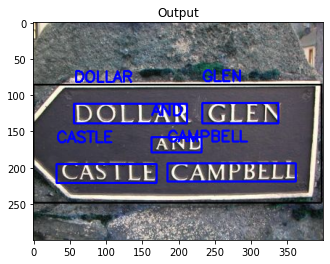

In [124]:
orig_image = orig.copy()
# Moving over the results and display on the image
for ((start_X, start_Y, end_X, end_Y), text) in results:
	print("{}\n".format(text))
	text = "".join([x if ord(x) < 128 else "" for x in text]).strip()
	cv2.rectangle(orig_image, (start_X, start_Y), (end_X, end_Y),
		(0, 0, 255), 2)
	cv2.putText(orig_image, text, (start_X, start_Y - 30),
		cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0,0, 255), 2)
plt.imshow(orig_image)
plt.title('Output')
plt.show()

OCR TEXT
AND




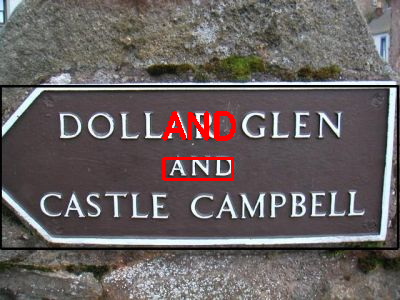

OCR TEXT
CASTLE




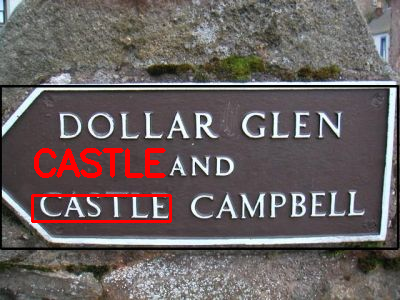

OCR TEXT
CAMPBELL




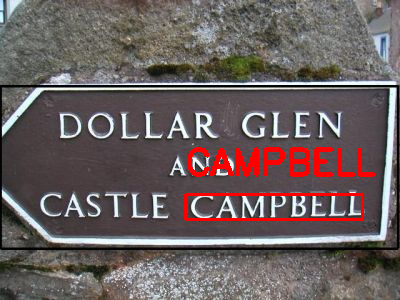

OCR TEXT
DOLLAR




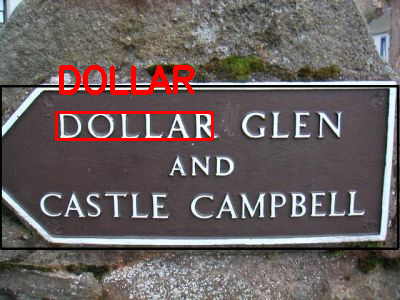

OCR TEXT
GLEN




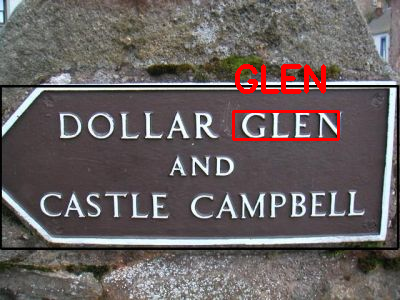

In [125]:
results = sorted(results, key=lambda r:r[1][0])
# loop over the results
for ((startX, startY, endX, endY), text) in results:
	print("OCR TEXT")
	print("{}\n".format(text))
	# strip out non-ASCII text so we can draw the text on the image
	# using OpenCV, then draw the text and a bounding box surrounding
	# the text region of the input image
	text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
	output = orig.copy()
	cv2.rectangle(output, (startX, startY), (endX, endY),
		(0, 0, 255), 2)
	cv2.putText(output, text, (startX, startY - 20),
		cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)
	cv2_imshow(output)
	cv2.waitKey(0)